In [2]:
# load packages
import calmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# load data
year_start = 1880
year_end = 2011
pi_test = np.load('../output/predictions/pi_test.npy')
mu_test = np.load('../output/predictions/mu_test.npy')
sigma_test = np.load('../output/predictions/sigma_test.npy')
## load temperatures
df_temp = pd.read_table('../data/climate/processed/temperatures/Complete_TAVG_daily.txt', sep=' ', header=None)
df_temp = df_temp[[2, 3, 4, 6]]
df_temp.columns = ['YEAR', 'MONTH', 'DAY', 'TEMP']

In [3]:
# loop over the data
weights_ = {}
for i in range(df_temp.shape[0]):
    temp_inst = df_temp['TEMP'][i]
    year_inst = df_temp['YEAR'][i]
    if year_inst < year_start or year_inst > year_end:
        continue
    else:
        id_row = int(year_inst - year_start)
        dens = wp.dgmm1d(temp_inst, mu_test[id_row], sigma_test[id_row], pi_test[id_row])
        w_1 = pi_test[id_row, 0] * norm.pdf(temp_inst, loc=mu_test[id_row, 0], scale=sigma_test[id_row, 0]) / dens
        w_2 = pi_test[id_row, 1] * norm.pdf(temp_inst, loc=mu_test[id_row, 1], scale=sigma_test[id_row, 1]) / dens
        w_3 = pi_test[id_row, 2] * norm.pdf(temp_inst, loc=mu_test[id_row, 2], scale=sigma_test[id_row, 2]) / dens
        day_key = 100 * df_temp['MONTH'][i] + df_temp['DAY'][i]
        if day_key in weights_.keys():
            weights_[day_key] += np.array([w_1, w_2, w_3])
        else:
            weights_[day_key] = np.array([w_1, w_2, w_3])

In [4]:
# loop over the weights_
weights_list = []
years_ = []
for day_key in weights_.keys():
    month_inst = int(day_key / 100)
    day_inst = day_key - month_inst * 100
    time_stamp = pd.Timestamp(2020, month_inst, day_inst, 0)
    years_.append(time_stamp)
    weights_list.append(weights_[day_key] / weights_[day_key].sum())
weights_array = np.array(weights_list)

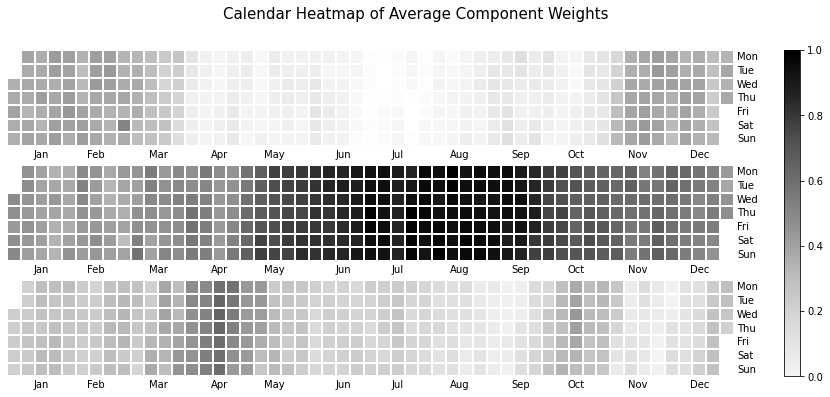

In [58]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import norm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
fig, axs = plt.subplots(3, figsize=(18, 6))
fig.suptitle('Calendar Heatmap of Average Component Weights', fontsize=15)
events = pd.Series(weights_array[:, 0], index=years_)
calmap.yearplot(events, year=2020, cmap='Greys', vmin=weights_array.min(), vmax=weights_array.max(), ax=axs[0])
#calmap.yearplot(events, year=2020, cmap='Blues', vmin=weights_array.min(), vmax=weights_array.max(), ax=axs[0])
events = pd.Series(weights_array[:, 1], index=years_)
calmap.yearplot(events, year=2020, cmap='Greys', vmin=weights_array.min(), vmax=weights_array.max(), ax=axs[1])
#calmap.yearplot(events, year=2020, cmap='Oranges', vmin=weights_array.min(), vmax=weights_array.max(), ax=axs[1])
events = pd.Series(weights_array[:, 2], index=years_)
calmap.yearplot(events, year=2020, cmap='Greys', vmin=weights_array.min(), vmax=weights_array.max(), ax=axs[2])
#calmap.yearplot(events, year=2020, cmap='Reds', vmin=weights_array.min(), vmax=weights_array.max(), ax=axs[2])
cm_raw = cm.get_cmap('Greys', 512)
colormap =  ListedColormap(cm_raw(np.linspace(0.1, 1, 256)))
normalize = mcolors.Normalize(vmin=0, vmax=1)
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
fig.colorbar(scalarmappaple, ax=axs, pad=0.05)
#plt.tight_layout()
plt.savefig('../output/figs/calendar_heatmap.pdf', bbox_inches='tight')  
plt.show()

In [33]:
# loop over the data
temps_dict = {}
for i in range(df_temp.shape[0]):
    temp_inst = df_temp['TEMP'][i]
    year_inst = df_temp['YEAR'][i]
    if year_inst < year_start or year_inst > year_end:
        continue
    else:
        day_key = 100 * df_temp['MONTH'][i] + df_temp['DAY'][i]
        if day_key in temps_dict.keys():
            temps_dict[day_key].append(df_temp['TEMP'][i])
        else:
            temps_dict[day_key] = [df_temp['TEMP'][i]]
temps_high = []       
temps_high_e = []       
temps_med = []
temps_low = []
temps_low_e = []
for day_key in temps_dict.keys():
    temps_low.append(np.quantile(temps_dict[day_key], 0.3))
    temps_med.append(np.median(temps_dict[day_key]))
    temps_high.append(np.quantile(temps_dict[day_key], 0.7))
    temps_low_e.append(np.quantile(temps_dict[day_key], 0.1))
    temps_high_e.append(np.quantile(temps_dict[day_key], 0.9))
    

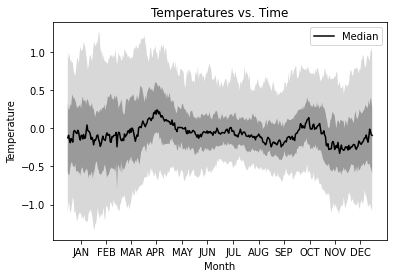

In [43]:
#plt.plot(temps_low, label = '25%')
plt.plot(temps_med, label = 'Median', color='Black')
#plt.plot(temps_high, label = '75%')
plt.fill_between(np.arange(len(temps_med)), temps_low, temps_high, alpha=0.7, color='Gray', edgecolor=None)
plt.fill_between(np.arange(len(temps_med)), temps_low_e, temps_high_e, alpha=0.3, color='Gray', edgecolor=None)
plt.title('Temperatures vs. Time')
plt.legend(loc=1)
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.xticks([16, 46, 76, 106, 137, 167, 198, 229, 259, 290, 320, 351], 
           ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'])
plt.savefig('../output/figs/daily_plot.pdf', bbox_inches='tight')  
plt.show()